In [1]:
from functools import cached_property
from dataclasses import dataclass
from collections import defaultdict
import numpy as np
import pandas as pd
import hist as hi
import matplotlib.pyplot as plt
from matplotlib.collections import PatchCollection
from matplotlib.patches import Polygon
from mpl_toolkits.axes_grid1 import make_axes_locatable
import mplhep as mh
mh.style.use(mh.styles.CMS)

In [58]:
np.sign(-1)

-1

In [2]:
@dataclass(frozen=True, unsafe_hash=True)
class RPCDetId:
    name: str
    region: int
    sector: int | None
    station: int | None
    roll: str
    wheel: int | None
    layer: int | None
    disk: int | None
    ring: int | None
    channel: int | None
    
    @staticmethod
    def check_if_barrel_name(name):
        # FIXME
        return name.startswith('W')

    @classmethod
    def from_barrel_name(cls, name):
        # TODO re
        # name='W-2_RB1in_S01_Backward'

        # 'W-2', 'RB1in', 'S01', 'Backward'
        wheel, station_str, sector, roll = name.split('_')
        # -2
        wheel = int(wheel[1:])
        # 1
        sector = int(sector[1:])
        # B
        roll = roll[0]

        # 1
        station = int(station_str[2])
        if station <= 2:
            layer = (station - 1) * 2 + 1
            if 'out' in station_str:
                layer += 1
        else:
            layer = 4 + (station - 2)
            roll += station_str[3:] ## There are suffix, +, -, ++, --, etc

        return cls(name=name, region=0,
            sector=sector,
            station=station,
            roll=roll,
            wheel=wheel,
            layer=layer,
            disk=None,
            ring=None,
            channel=None
        )
            
            
    @classmethod
    def from_endcap_name(cls, name):
        # name='RE-4_R2_CH19_B'
        # 'RE-4', 'R2', 'CH19', 'B'
        signed_disk, ring, channel, roll = name.split('_')
        signed_disk = int(signed_disk[2:])
        ring = int(ring[1:])
        channel = int(channel[2:])
        disk = abs(signed_disk)
        region = np.sign(signed_disk)
        
        return cls(
            name=name,
            region=region,
            sector=None,
            station=None,
            roll=roll,
            wheel=None,
            layer=None,
            disk=disk,
            ring=ring,
            channel=channel
        )
    
    @classmethod
    def from_name(cls, name):
        if name.startswith("W"):
            return cls.from_barrel_name(name)
        else:
            return cls.from_endcap_name(name)

    @property
    def barrel(self) -> bool:
        return self.region == 0

    @property
    def endcap(self):
        return abs(self.region) == 1

    @property
    def irpc(self):
        return self.endcap and self.disk in (3, 4) and self.ring == 1
    
    
    @cached_property
    def key(self) -> str:
        if self.barrel:
            key = '_'.join(self.name.split('_')[1:2])
            key = key.strip('+-')
        else:
            key = f'RE{self.region * self.disk:+d}'
        return key

In [3]:
df_eff = pd.read_csv('./efficiency.csv', index_col=0)

In [4]:
barrel_mask = df_eff.roll.apply(RPCDetId.check_if_barrel_name).to_numpy()
endcap_mask = ~barrel_mask

In [7]:
df_eff[barrel_mask]

,roll,efficiency,err_low,err_high,denominator
0,W-2_RB1in_S01_Backward,0.965803,0.001176,0.001139,25558
1,W-2_RB1in_S01_Forward,0.972282,0.001148,0.001105,22152
2,W-2_RB1out_S01_Backward,0.000000,0.000000,0.000078,23576
3,W-2_RB1out_S01_Forward,0.000000,0.000000,0.000090,20400
4,W-2_RB1in_S02_Backward,0.954748,0.001345,0.001309,25325
...,...,...,...,...,...
1015,W+2_RB4_S11_Forward,0.847331,0.003534,0.003469,10847
1016,W+2_RB4-_S12_Backward,0.979736,0.001743,0.001613,7649
1017,W+2_RB4+_S12_Backward,0.981880,0.001333,0.001246,11479
1018,W+2_RB4-_S12_Forward,0.898414,0.003580,0.003473,7629


In [8]:
df_eff[endcap_mask]

,roll,efficiency,err_low,err_high,denominator
1020,RE+1_R2_CH03_A,0.984247,0.002595,0.002254,3047
1021,RE+1_R2_CH03_B,0.974991,0.003263,0.002913,2879
1022,RE+1_R2_CH03_C,0.979735,0.001917,0.001761,6415
1023,RE+1_R2_CH05_A,0.951484,0.004152,0.003851,3133
1024,RE+1_R2_CH05_B,0.838201,0.007035,0.006802,2979
...,...,...,...,...,...
2747,RE-4_R2_CH19_B,0.974492,0.003277,0.002931,2901
2748,RE-4_R2_CH19_C,0.959321,0.004318,0.003937,2532
2749,RE-4_R3_CH19_A,0.980177,0.003723,0.003181,1917
2750,RE-4_R3_CH19_B,0.972831,0.003074,0.002783,3423


In [9]:
from hist.hist import Hist

In [15]:
axis = hi.axis.Regular(200, 0, 100)

h_barrel = Hist(axis)
h_endcap = Hist(axis)

In [16]:
h_barrel.fill(100 * df_eff[barrel_mask]['efficiency'])
h_endcap.fill(100 * df_eff[endcap_mask]['efficiency'])

Hist(Regular(200, 0, 100, label='Axis 0'), storage=Double()) # Sum: 1732.0

In [52]:

def plot_hist(hist,
              color,
              edgecolor,
              ax=None
):
    ax = ax or plt.gca()
    
    hist.plot(ax=ax, yerr=False, histtype='fill', color=color, edgecolor=edgecolor, linewidth=2)

    ax.set_xlabel('Efficiency [%]')
    ax.set_ylabel('Number of Rolls')

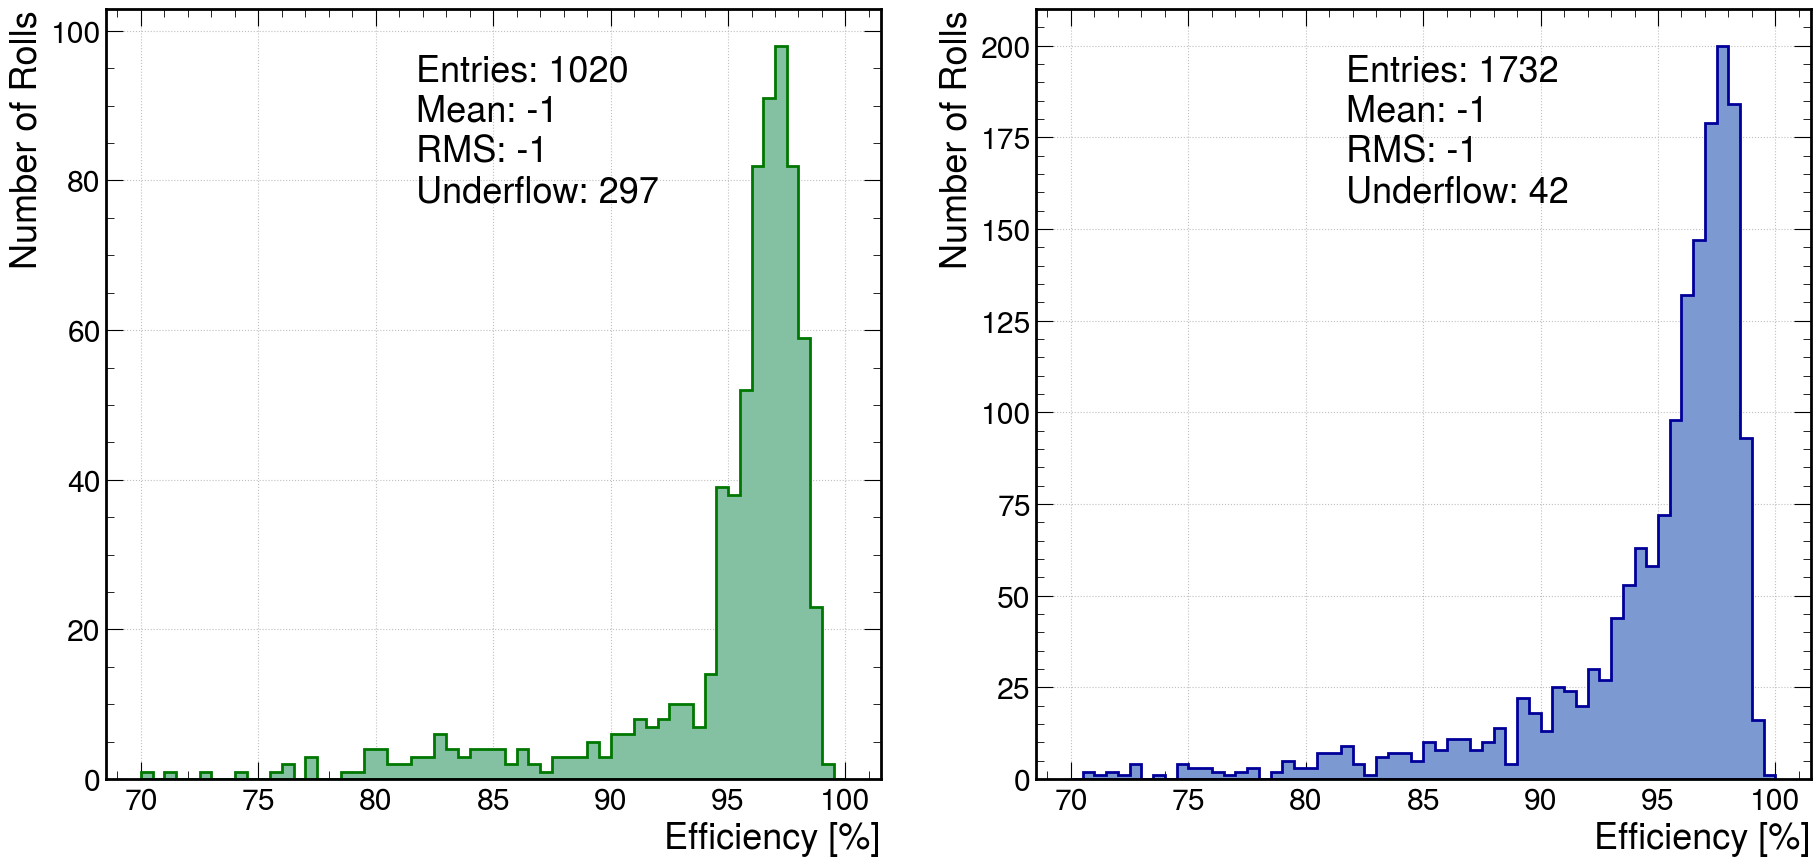

In [55]:
fig, axarr = plt.subplots(ncols=2, figsize=(22, 10))
for ax, hist, color, edgecolor in zip(axarr.ravel(), [h_barrel, h_endcap], ['#84c1a3', '#7c99d1'], ["#007700", "#000099"]):
    plot_hist(hist[70j:], color=color, edgecolor=edgecolor, ax=ax)
    
    entries = hist.counts().sum().astype(int)
    mean = -1
    rms = -1
    underflow = hist[:70j].counts().sum().astype(int)
    text = f'Entries: {entries:}\nMean: {mean}\nRMS: {rms}\nUnderflow: {underflow}'
    
    ax.annotate(text, (0.4, 0.75), xycoords='axes fraction')
    
    # grid
    ax.set_axisbelow(True)
    ax.grid()

In [ ]:
ax.annotate?